In [1]:
import os
import random
import numpy as np
import pandas as pd

import torch
# Модуль для построения нейросетей
import torch.nn as nn
# Все, что связано с функциями (функции потерь, активации и пр.)
import torch.nn.functional as F
# Оптимизаторы из торча достаем
import torch.optim as optim
# DataLoader позволяет загружать данные из Dataset и имеет различные функции (Shuffle, Batching, Multiprocessing)
from torch.utils.data import DataLoader, Dataset

# Красивый прогресс-бар
from tqdm.notebook import tqdm

# classification_report - сводная таблица со всеми метриками
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

# Очистка результата выполнения функции display  и отрисовки только актуального значения
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Нормализация данных
from sklearn.preprocessing import StandardScaler

# Установка общего стиля графиков seaborn
sns.set_theme()

# 0. Обеспечение воспроизводимости

In [2]:
# Устанавливаем random_seed там, где это только возможно
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


# 1. Загрузка датасета

In [3]:
url = 'https://github.com/pacifikus/itmo_dl_course/raw/master/HW/hw_1/cybersequrity.csv'
df = pd.read_csv(url)
df.head()

,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
0,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.044444,1
1,26,8,0.0,0,0,5,3,3,3,7,0.073171,0.073171,9,0.073171,0.121951,1
2,26,8,0.0,0,0,9,7,7,7,11,0.152174,0.152174,13,0.152174,0.195652,1
3,26,8,0.0,0,0,3,1,1,2,6,0.022222,0.022222,9,0.044444,0.066667,1
4,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.048780,0


In [23]:
df.shape

(10000, 16)

# 2. Подготовка данных

## 2.1 Разделение на TVT

In [4]:
# В датафрейме X убираем целевую переменную, y - наша целевая переменная
X, y = df.drop('Class', axis=1), df['Class']
# Делим исходный датасет на обучающую и тестовую части
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42, stratify = y)
# И уже далее формируем валидационную выборку из тестовой
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.50, random_state = 42, stratify = y_test)

In [5]:
scaler = StandardScaler()

# Применяем StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

## 2.2 Обертка данных

In [6]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        # X - датафрейм, X.values - это просто массив всех значений, мы его превращаем в тензор
        self.X = torch.Tensor(X)
        # Для таргета немного по-другому, reshape(-1, 1) - минус один означает вот сколько там элементов, столькими строками и заполнить;
        # Один - значит одна колонка
        self.y = torch.from_numpy(y.values).reshape(-1, 1).float()
        
    def __len__(self):
        # Возвращаем количество строк
        return self.X.shape[0]
        
    def __getitem__(self, index):
        # Получаем композицию (признак + таргет)
        return (self.X[index], self.y[index])


In [7]:
train_dataset = CustomDataset(X_train_scaled, y_train)
val_dataset = CustomDataset(X_val_scaled, y_val)
test_dataset = CustomDataset(X_test_scaled, y_test)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# Shuffle = False для обеспечения воспроизводимости
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Реализация нейросети

In [15]:
class CyberSecurityNN(nn.Module):
    # num_labels - количество выходных нейронов, для данной задачи (0, 1)
    # input_size - количество входных нейронов, входных параметров
    # n_linear_layers - количество слоев нейросети
    # activation - функция активации
    
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.Sigmoid):
        
        # Надо не забыть вызвать конструктор базового класса, т.к. что-то может не проинициализироваться
        super(CyberSecurityNN, self).__init__()
        
        # Инициализация списка слоев, изначально просто первый слой добавляем (тут же и веса инициализируются равномерным распределением!!!)
        layers = [nn.Linear(input_size, hidden_size), activation()]
        
        # Далее - оставшиеся n-2 слоев, 
        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation())
            
        # Последний слой
        layers.append(nn.Linear(hidden_size, num_labels))
        
        # Последовательный контейнер для хранений нейросети в PyTorch. Последовательно передается структура слоя, а потом функция активации
        self.layers = nn.Sequential(*layers)

    # x - вход для нейросети
    def forward(self, x):
        
        # На выходе (только на выходе!!!) преобразуем в [0, 1]
        y_pred = torch.sigmoid(self.layers(x))
        # Выдаем результаты прогноза нейросети 
        return y_pred

# 4. Первичная инициализация

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [129]:
# Гиперпараметры

input_size = 15  # количество входных признаков (без таргета!)
hidden_size = 15 # количество нейронов на скрытом слое
num_labels = 1   # бинарный выход
n_linear_layers = 2 # количество слоев
activation = nn.ReLU  # активация
learning_rate = 0.001 # скорость обучения
num_epochs = 100
batch_size = 16

In [130]:
# Создаем модель с нашими параметрами
model = CyberSecurityNN(num_labels=num_labels, input_size=input_size, hidden_size=hidden_size, n_linear_layers=n_linear_layers, activation=activation)
# Помещаем в наш девайс
model = model.to(device)

In [131]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss, т.к. классификация бинарная
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # Определяем оптимизатор

# 5. Цикл обучения

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.6769, Val Loss: 0.6836
Epoch [2/100], Train Loss: 0.6372, Val Loss: 0.6629
Epoch [3/100], Train Loss: 0.6089, Val Loss: 0.6324
Epoch [4/100], Train Loss: 0.5780, Val Loss: 0.6209
Epoch [5/100], Train Loss: 0.5716, Val Loss: 0.5768
Epoch [6/100], Train Loss: 0.5620, Val Loss: 0.5824
Epoch [7/100], Train Loss: 0.5446, Val Loss: 0.5924
Epoch [8/100], Train Loss: 0.5528, Val Loss: 0.5802
Epoch [9/100], Train Loss: 0.5553, Val Loss: 0.5907
Epoch [10/100], Train Loss: 0.5413, Val Loss: 0.5522
Epoch [11/100], Train Loss: 0.5387, Val Loss: 0.5654
Epoch [12/100], Train Loss: 0.5400, Val Loss: 0.5935
Epoch [13/100], Train Loss: 0.5358, Val Loss: 0.5824
Epoch [14/100], Train Loss: 0.5498, Val Loss: 0.5816
Epoch [15/100], Train Loss: 0.5463, Val Loss: 0.5713
Epoch [16/100], Train Loss: 0.5447, Val Loss: 0.5891
Epoch [17/100], Train Loss: 0.5369, Val Loss: 0.5866
Epoch [18/100], Train Loss: 0.5420, Val Loss: 0.5888
Epoch [19/100], Train Loss: 0.5347, Val Loss: 0.5631
Ep

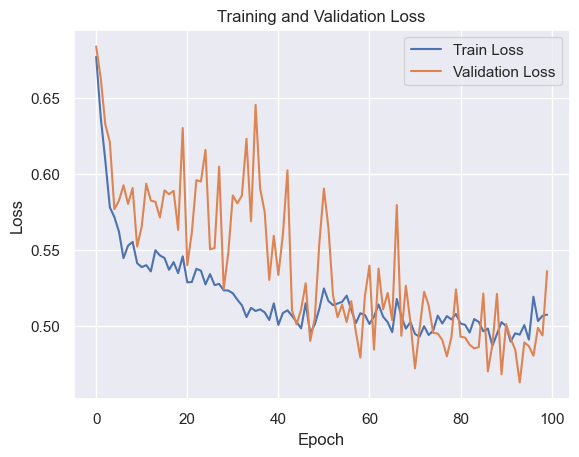

In [132]:
# Собираем наши лоссы для каждого шага
train_losses = []
val_losses = []

# Обучение (train-loop)
for epoch in tqdm(range(num_epochs)):
    # Переводим в режим обучения, см. подробнее: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    model.train()
    # Считаем общий лосс, чтобы потом вычислять среднее
    running_train_loss = 0.0

    # Для признаков и таргетов
    for inputs, labels in train_dataloader:
        # Помещаем в наш девайс, это один батч у нас
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass (т.е. наши данные проходят через модель (с текущими весами) и затем смотрим на лосс, как часто модель ошибалась)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass и обновление весов
        # Обнуляем градиенты, которые уже не актуальны
        optimizer.zero_grad()
        # Обратный проход по структуре
        loss.backward()
        # Обновление весов
        optimizer.step()
        # Суммируем лосс
        running_train_loss += loss.item()

    # Средняя функция потерь на тренировочной выборке за эпоху, чтобы не зависеть от аномалий всякого рода
    train_loss = running_train_loss / len(train_dataloader)
    # Добавляем тренировочный лосс
    train_losses.append(train_loss)

    # Валидация (eval-loop)
    # Переводим в режим оценивания
    model.eval()
    running_val_loss = 0.0
    # Отключаем вычисление градиентов
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # Средняя функция потерь на валидационной выборке за эпоху
    val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Визуализация функции потерь
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 6. Оценка точности предсказаний

In [133]:
from sklearn.metrics import classification_report

# Тестирование модели
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Построение отчета о классификации
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

         0.0       0.76      0.88      0.81       981
         1.0       0.86      0.73      0.79      1019

    accuracy                           0.80      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.81      0.80      0.80      2000



До этого пункта эмпирически уже были подобраны гиперпараметры, но ничего с сильно лучшими результатами не получилось...

<div style="text-align: center;">
    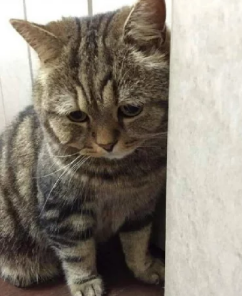
</div>

# 7. Улучшение архитектуры нейросети

Зададим новые гиперпараметры. В частности, для применения BatchNorm лучше использовать бОльший размер батчей

In [193]:
input_size = 15  # количество входных признаков (без таргета!)
hidden_size = 15 # количество нейронов на скрытом слое
num_labels = 1  # бинарный выход
n_linear_layers = 2 # количество слоев
activation = nn.Tanh  # активация
learning_rate = 0.01 # скорость обучения
num_epochs = 100
batch_size = 16

In [194]:
class CyberSecurityNN(nn.Module):
    # num_labels - количество выходных нейронов, для данной задачи (0, 1)
    # input_size - количество входных нейронов, входных параметров
    # n_linear_layers - количество слоев нейросети
    # activation - функция активации
    # dropout_prob - веороятность, с которой мы "дропнем" определенный нейрон
    
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU, dropout_prob = 0.3):
        
        # Надо не забыть вызвать конструктор базового класса, т.к. что-то может не проинициализироваться
        super(CyberSecurityNN, self).__init__()
        
        # Инициализация списка слоев
        layers = [nn.Linear(input_size, hidden_size)]

        layers.append(activation())  # Функция активации

        layers.append(nn.Dropout(dropout_prob))  # Dropout

        
        # Добавляем оставшиеся слои
        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))

            layers.append(activation())  # Функция активации

            layers.append(nn.Dropout(dropout_prob))  # Dropout

            
        # Последний слой
        layers.append(nn.Linear(hidden_size, num_labels))
        
        # Последовательный контейнер для хранений нейросети в PyTorch. Последовательно передается структура слоя, а потом функция активации
        self.layers = nn.Sequential(*layers)

    # x - вход для нейросети
    def forward(self, x):
        
        # На выходе (только на выходе!!!) преобразуем в [0, 1]
        y_pred = torch.sigmoid(self.layers(x))
        # Выдаем результаты прогноза нейросети 
        return y_pred
        

In [195]:
# Создаем модель с нашими параметрами
model = CyberSecurityNN(num_labels=num_labels, input_size=input_size, hidden_size=hidden_size, n_linear_layers=n_linear_layers, activation=activation)
# Помещаем в наш девайс
model = model.to(device)

In [196]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss, т.к. классификация бинарная
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # Определяем оптимизатор

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.6773, Val Loss: 0.6524
Epoch [2/100], Train Loss: 0.6611, Val Loss: 0.6291
Epoch [3/100], Train Loss: 0.6284, Val Loss: 0.5794
Epoch [4/100], Train Loss: 0.6126, Val Loss: 0.5720
Epoch [5/100], Train Loss: 0.6003, Val Loss: 0.5503
Epoch [6/100], Train Loss: 0.5849, Val Loss: 0.5753
Epoch [7/100], Train Loss: 0.5781, Val Loss: 0.5402
Epoch [8/100], Train Loss: 0.5680, Val Loss: 0.5203
Epoch [9/100], Train Loss: 0.5747, Val Loss: 0.5300
Epoch [10/100], Train Loss: 0.5616, Val Loss: 0.5270
Epoch [11/100], Train Loss: 0.5618, Val Loss: 0.6053
Epoch [12/100], Train Loss: 0.5625, Val Loss: 0.5318
Epoch [13/100], Train Loss: 0.5411, Val Loss: 0.5309
Epoch [14/100], Train Loss: 0.5450, Val Loss: 0.4893
Epoch [15/100], Train Loss: 0.5430, Val Loss: 0.5212
Epoch [16/100], Train Loss: 0.5446, Val Loss: 0.4946
Epoch [17/100], Train Loss: 0.5365, Val Loss: 0.5302
Epoch [18/100], Train Loss: 0.5329, Val Loss: 0.5171
Epoch [19/100], Train Loss: 0.5350, Val Loss: 0.4840
Ep

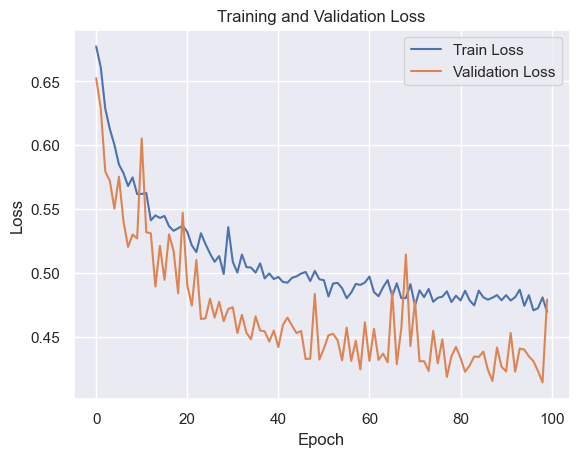

In [197]:
# Собираем наши лоссы для каждого шага
train_losses = []
val_losses = []

# Обучение (train-loop)
for epoch in tqdm(range(num_epochs)):
    # Переводим в режим обучения, см. подробнее: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    model.train()
    # Считаем общий лосс, чтобы потом вычислять среднее
    running_train_loss = 0.0

    # Для признаков и таргетов
    for inputs, labels in train_dataloader:
        # Помещаем в наш девайс, это один батч у нас
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass (т.е. наши данные проходят через модель (с текущими весами) и затем смотрим на лосс, как часто модель ошибалась)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass и обновление весов
        # Обнуляем градиенты, которые уже не актуальны
        optimizer.zero_grad()
        # Обратный проход по структуре
        loss.backward()
        # Обновление весов
        optimizer.step()
        # Суммируем лосс
        running_train_loss += loss.item()

    # Средняя функция потерь на тренировочной выборке за эпоху, чтобы не зависеть от аномалий всякого рода
    train_loss = running_train_loss / len(train_dataloader)
    # Добавляем тренировочный лосс
    train_losses.append(train_loss)

    # Валидация (eval-loop)
    # Переводим в режим оценивания
    model.eval()
    running_val_loss = 0.0
    # Отключаем вычисление градиентов
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # Средняя функция потерь на валидационной выборке за эпоху
    val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Визуализация функции потерь
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [198]:
from sklearn.metrics import classification_report

# Тестирование модели
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Построение отчета о классификации
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

         0.0       0.79      0.72      0.75       981
         1.0       0.75      0.81      0.78      1019

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000

